In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm.auto import tqdm
import numpy as np
import warnings
import os

# ===================================================================
# STEP 1: 실험 환경 설정
# ===================================================================

# --- 하이퍼파라미터 ---
BATCH_SIZE = 64
BLOCK_SIZE = 64
MAX_ITERS = 30000 
EVAL_INTERVAL = 1000
HOMOLOGY_INTERVAL = 100
GRAD_SIMILARITY_INTERVAL = 100
LEARNING_RATE = 5e-4 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EVAL_ITERS = 200
N_EMBD = 256
N_HEAD = 8
N_LAYER = 6
DROPOUT = 0.2
WARMUP_ITERS = 2000
LR_DECAY_ITERS = 30000
MIN_LR = 5e-5
LOG_INTERVAL = 100


# --- 분석할 실험 그룹 및 시드 정의 ---
SEEDS = [42, 123, 2024]
EXPERIMENTS = {
    "Vanilla": {
        "use_regularizer": False, "lambda_reg": 0.0, "target_score": 0.0
    },
    "Forced_Chaos ": {
        "use_regularizer": True, "lambda_reg": 1.0, "target_score": 2.0
    },
    "Forced_Collapse ": {
        "use_regularizer": True, "lambda_reg": 1.0, "target_score": -0.0010
    }
}

# ===================================================================
# STEP 2: 모델, 분석, 훈련 로직
# ===================================================================
def prepare_data(device):
    url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    text = requests.get(url).text
    chars = sorted(list(set(text)))
    vocab_size = len(chars)
    stoi = {ch: i for i, ch in enumerate(chars)}
    itos = {i: ch for i, ch in enumerate(chars)}
    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[i] for i in l])
    data = torch.tensor(encode(text), dtype=torch.long)
    n = int(0.9 * len(data))
    train_data, val_data = data[:n], data[n:]
    return train_data, val_data, vocab_size, decode

def get_batch(split, train_data, val_data, block_size, batch_size, device):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y
    
def _init_weights(module):
    if isinstance(module, (nn.Linear)):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        if module.bias is not None: torch.nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

class UnitCircleNormalization(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon
    def forward(self, z):
        z1, z2 = z[..., 0:2], z[..., 2:4]
        norm1 = torch.norm(z1, p=2, dim=-1, keepdim=True)
        norm2 = torch.norm(z2, p=2, dim=-1, keepdim=True)
        return torch.cat([z1 / (norm1 + self.epsilon), z2 / (norm2 + self.epsilon)], dim=-1)

class EncoderV3(nn.Module):
    def __init__(self, d_model, dropout):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(d_model, d_model // 2), nn.GELU(), nn.Dropout(dropout), nn.Linear(d_model // 2, 4))
        self.normalizer = UnitCircleNormalization()
    def forward(self, x): return self.normalizer(self.net(x))

class LatentDynamicsDirect4D(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(4, 1024), nn.GELU(), nn.Dropout(dropout), nn.Linear(1024, 4))
        self.normalizer = UnitCircleNormalization()
    def forward(self, z): return self.normalizer(self.net(z))

class DecoderV3(nn.Module):
    def __init__(self, d_model, dropout):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(4, 4 * d_model), nn.GELU(), nn.Dropout(dropout), nn.Linear(4 * d_model, d_model))
    def forward(self, z): return self.net(z)

class LatentTorusTransformerBlockV3(nn.Module):
    def __init__(self, n_embd, n_head, dropout):
        super().__init__()
        self.ln1, self.ln2 = nn.LayerNorm(n_embd), nn.LayerNorm(n_embd)
        self.sa = nn.MultiheadAttention(n_embd, n_head, dropout=dropout, batch_first=True)
        self.encoder = EncoderV3(n_embd, dropout)
        self.latent_dynamics = LatentDynamicsDirect4D(dropout)
        self.decoder = DecoderV3(n_embd, dropout)
    def forward(self, x):
        x = x + self.sa(self.ln1(x), self.ln1(x), self.ln1(x))[0]
        z = self.encoder(self.ln2(x))
        z_next = self.latent_dynamics(z)
        x = x + self.decoder(z_next)
        return x

class LatentTorusTransformerV3(nn.Module):
    def __init__(self, vocab_size, n_embd, block_size, n_head, n_layer, dropout):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[LatentTorusTransformerBlockV3(n_embd, n_head, dropout) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.apply(_init_weights)
        
    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=DEVICE))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        logits = self.lm_head(self.ln_f(x))
        loss = F.cross_entropy(logits.view(B*T, -1), targets.view(B*T)) if targets is not None else None
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, block_size, temperature=0.8):
        self.eval()
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        self.train()
        return idx

def run_homological_analysis(dynamics_model, device, n_points=200, tol=0.2):
    dynamics_model.eval()
    t = torch.linspace(0, 2*np.pi, n_points, device=device)
    loop1 = torch.stack([torch.cos(t), torch.sin(t), torch.ones_like(t), torch.zeros_like(t)], dim=1)
    loop2 = torch.stack([torch.ones_like(t), torch.zeros_like(t), torch.cos(t), torch.sin(t)], dim=1)
    transformed_loops_angle = []
    with torch.no_grad():
        for loop_trig in [loop1, loop2]:
            transformed_trig = dynamics_model(loop_trig)
            cos1, sin1, cos2, sin2 = transformed_trig.T
            theta_out, p_out = torch.atan2(sin1, cos1), torch.atan2(sin2, cos2)
            transformed_loops_angle.append(torch.stack([theta_out, p_out], dim=1).cpu().numpy())
    M = np.zeros((2, 2), dtype=int)
    for i, loop in enumerate(transformed_loops_angle):
        unwrapped = np.unwrap(loop, axis=0)
        raw_windings = (unwrapped[-1] - unwrapped[0]) / (2 * np.pi)
        approx_windings = np.round(raw_windings).astype(int)
        mask = ~np.isclose(raw_windings, approx_windings, atol=tol)
        if np.any(mask):
            warnings.warn(f"Winding deviation {raw_windings[mask]} exceeds tol={tol}, using nearest ints {approx_windings[mask]}", UserWarning)
        M[:, i] = approx_windings
    eigs = np.linalg.eigvals(M)
    score = np.log(np.max(np.abs(eigs)) + 1e-9)
    return M, score

def compute_jacobian_proxy_score(dynamics_model, device, n_samples=10):
    dynamics_model.eval()
    random_angles = torch.rand(n_samples, 2, device=device) * 2 * math.pi
    cos_vals, sin_vals = torch.cos(random_angles), torch.sin(random_angles)
    z = torch.cat([cos_vals[:,0:1], sin_vals[:,0:1], cos_vals[:,1:2], sin_vals[:,1:2]], dim=1)
    compute_jacobian = torch.func.jacrev(dynamics_model)
    jacobians = torch.vmap(compute_jacobian)(z)
    jitter = 1e-6 * torch.eye(jacobians.size(-1), device=device)
    jacobians = jacobians + jitter
    singular_values = torch.linalg.svdvals(jacobians)
    max_singular_values = singular_values[:, 0]
    proxy_score = torch.log(max_singular_values + 1e-9)
    dynamics_model.train()
    return proxy_score.mean()

@torch.no_grad()
def estimate_loss(model, train_data, val_data, block_size, batch_size, device, eval_iters):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, train_data, val_data, block_size, batch_size, device)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

def get_lr(it):
    if it < WARMUP_ITERS: return LEARNING_RATE * it / WARMUP_ITERS
    if it > LR_DECAY_ITERS: return MIN_LR
    decay_ratio = (it - WARMUP_ITERS) / (LR_DECAY_ITERS - WARMUP_ITERS)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return MIN_LR + coeff * (LEARNING_RATE - MIN_LR)

# ===================================================================
# STEP 4: 모듈화된 단일 실험 실행 함수
# ===================================================================

def run_single_experiment(config, train_data, val_data, vocab_size, decode):
    run_name = config['run_name']
    seed = config['seed']
    print(f"--- Starting Run: {run_name} (Seed: {seed}) ---")

    torch.manual_seed(seed)
    np.random.seed(seed)
    
    model = LatentTorusTransformerV3(vocab_size, N_EMBD, BLOCK_SIZE, N_HEAD, N_LAYER, DROPOUT).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    log = []
    pbar = tqdm(range(MAX_ITERS), desc=f"{run_name} Seed {seed}")
    
    for it in pbar:
        lr = get_lr(it)
        for param_group in optimizer.param_groups: param_group['lr'] = lr
        xb, yb = get_batch('train', train_data, val_data, BLOCK_SIZE, BATCH_SIZE, DEVICE)
        
        logits, loss_ce = model(xb, yb)
        total_loss = loss_ce
        
        log_entry = {'iter': it, 'lr': lr}

        if config['use_regularizer']:
            avg_proxy_score = 0
            for i in range(N_LAYER):
                dynamics_model = model.blocks[i].latent_dynamics
                avg_proxy_score += compute_jacobian_proxy_score(dynamics_model, DEVICE)
            avg_proxy_score /= N_LAYER
            loss_reg = config['lambda_reg'] * (avg_proxy_score - config['target_score'])**2
            total_loss = loss_ce + loss_reg

            if it % LOG_INTERVAL == 0:
                dynamics_params = [p for block in model.blocks for p in block.latent_dynamics.parameters() if p.requires_grad]
                if dynamics_params:
                    grad_ce = torch.autograd.grad(loss_ce, dynamics_params, retain_graph=True, allow_unused=True)
                    grad_reg = torch.autograd.grad(loss_reg, dynamics_params, retain_graph=True, allow_unused=True)
                    grad_ce_flat = torch.cat([g.flatten() for g in grad_ce if g is not None])
                    grad_reg_flat = torch.cat([g.flatten() for g in grad_reg if g is not None])
                    if torch.norm(grad_ce_flat) > 0 and torch.norm(grad_reg_flat) > 0:
                        similarity = F.cosine_similarity(grad_ce_flat, grad_reg_flat, dim=0)
                        log_entry['grad_similarity'] = similarity.item()

        optimizer.zero_grad(set_to_none=True)
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        log_entry['train_loss'] = total_loss.item()
        
        if it % LOG_INTERVAL == 0 or it == MAX_ITERS - 1:
            avg_homology_score = 0
            for i in range(N_LAYER):
                dynamics_model = model.blocks[i].latent_dynamics
                _, score = run_homological_analysis(dynamics_model, DEVICE)
                log_entry[f'homology_layer_{i}'] = score
                avg_homology_score += score
            log_entry['avg_homology_score'] = avg_homology_score / N_LAYER
        
        if it % EVAL_INTERVAL == 0 or it == MAX_ITERS - 1:
            losses = estimate_loss(model, train_data, val_data, BLOCK_SIZE, BATCH_SIZE, DEVICE, EVAL_ITERS)
            log_entry['val_loss'] = losses['val']
            log_entry['perplexity'] = math.exp(losses['val']) if losses['val'] < 20 else float('inf')
            pbar.set_description(f"{run_name} Seed {seed} | Val Loss: {losses['val']:.4f}")
        
        if any(key in log_entry for key in ['val_loss', 'homology_layer_0', 'grad_similarity']):
            log.append(log_entry)

    df_log = pd.DataFrame(log).set_index('iter')
    
    log_dir = "logs"
    models_dir = "models"
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(models_dir, exist_ok=True)
    
    df_log.to_csv(os.path.join(log_dir, f"{run_name}_seed_{seed}.csv"))

    print(f"--- Finished Run: {run_name} (Seed: {seed}) ---")
    context = torch.zeros((1, 1), dtype=torch.long, device=DEVICE)
    generated_text = model.generate(context, max_new_tokens=500, block_size=BLOCK_SIZE)[0].tolist()
    with open(os.path.join(log_dir, f"generated_text_{run_name}_seed_{seed}.txt"), "w", encoding='utf-8') as f:
        f.write(decode(generated_text))

    model_path = os.path.join(models_dir, f"{run_name}_seed_{seed}.pt")
    torch.save(model.state_dict(), model_path)
    print(f"Model weights saved to {model_path}")

# ===================================================================
# STEP 5: 메인 실행부
# ===================================================================

if __name__ == '__main__':
    train_data, val_data, vocab_size, decode = prepare_data(DEVICE)
    
    for exp_name, exp_config in EXPERIMENTS.items():
        for seed in SEEDS:
            config = {
                'run_name': exp_name.replace(' ', '_'),
                'seed': seed,
                **exp_config
            }
            run_single_experiment(config, train_data, val_data, vocab_size, decode)
            
    print("\n--- All training runs completed. ---")
    print("You can now run the analysis script to evaluate the saved models.")


--- Starting Run: Vanilla (Seed: 42) ---


Vanilla Seed 42:   0%|          | 0/30000 [00:00<?, ?it/s]

--- Finished Run: Vanilla (Seed: 42) ---
Model weights saved to models/Vanilla_seed_42.pt
--- Starting Run: Vanilla (Seed: 123) ---


Vanilla Seed 123:   0%|          | 0/30000 [00:00<?, ?it/s]

--- Finished Run: Vanilla (Seed: 123) ---
Model weights saved to models/Vanilla_seed_123.pt
--- Starting Run: Vanilla (Seed: 2024) ---


Vanilla Seed 2024:   0%|          | 0/30000 [00:00<?, ?it/s]

--- Finished Run: Vanilla (Seed: 2024) ---
Model weights saved to models/Vanilla_seed_2024.pt
--- Starting Run: Forced_Chaos_ (Seed: 42) ---


Forced_Chaos_ Seed 42:   0%|          | 0/30000 [00:00<?, ?it/s]

--- Finished Run: Forced_Chaos_ (Seed: 42) ---
Model weights saved to models/Forced_Chaos__seed_42.pt
--- Starting Run: Forced_Chaos_ (Seed: 123) ---


Forced_Chaos_ Seed 123:   0%|          | 0/30000 [00:00<?, ?it/s]

--- Finished Run: Forced_Chaos_ (Seed: 123) ---
Model weights saved to models/Forced_Chaos__seed_123.pt
--- Starting Run: Forced_Chaos_ (Seed: 2024) ---


Forced_Chaos_ Seed 2024:   0%|          | 0/30000 [00:00<?, ?it/s]

--- Finished Run: Forced_Chaos_ (Seed: 2024) ---
Model weights saved to models/Forced_Chaos__seed_2024.pt
--- Starting Run: Forced_Collapse_ (Seed: 42) ---


Forced_Collapse_ Seed 42:   0%|          | 0/30000 [00:00<?, ?it/s]

--- Finished Run: Forced_Collapse_ (Seed: 42) ---
Model weights saved to models/Forced_Collapse__seed_42.pt
--- Starting Run: Forced_Collapse_ (Seed: 123) ---


Forced_Collapse_ Seed 123:   0%|          | 0/30000 [00:00<?, ?it/s]

--- Finished Run: Forced_Collapse_ (Seed: 123) ---
Model weights saved to models/Forced_Collapse__seed_123.pt
--- Starting Run: Forced_Collapse_ (Seed: 2024) ---


Forced_Collapse_ Seed 2024:   0%|          | 0/30000 [00:00<?, ?it/s]

--- Finished Run: Forced_Collapse_ (Seed: 2024) ---
Model weights saved to models/Forced_Collapse__seed_2024.pt

--- All training runs completed. ---
You can now run the analysis script to evaluate the saved models.



--- Generating Training Dynamics Plots ---


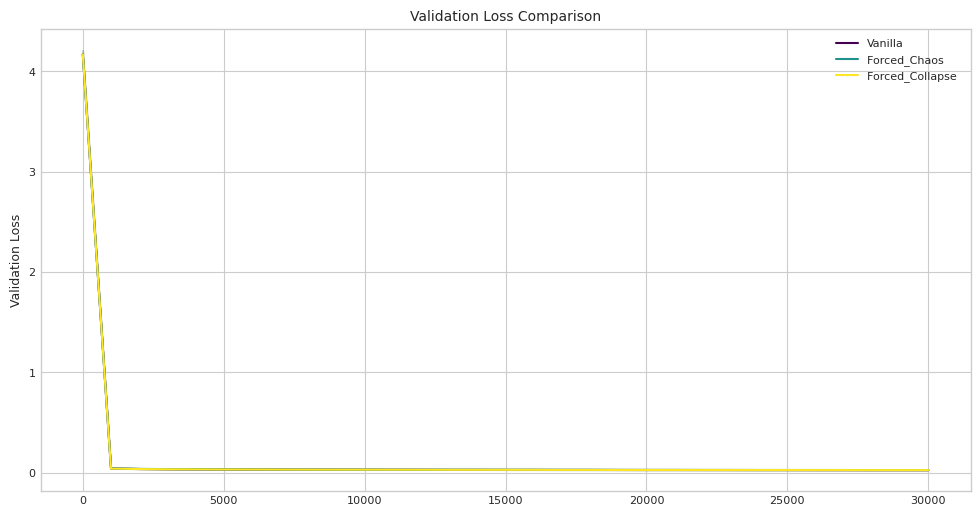

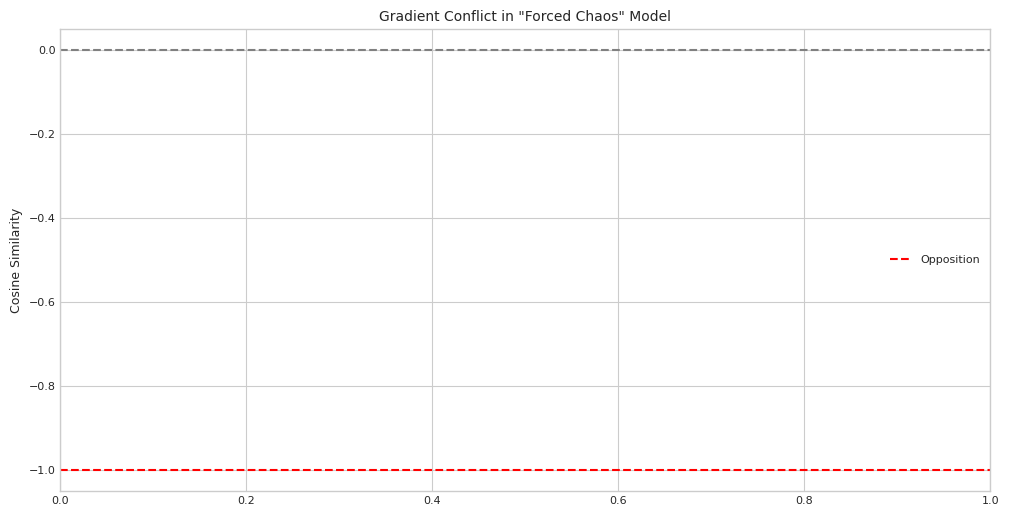

/tmp/ipykernel_2894213/3563557849.py:300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df[radius_col] = np.exp(exp_df[score_col])
/tmp/ipykernel_2894213/3563557849.py:300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df[radius_col] = np.exp(exp_df[score_col])
/tmp/ipykernel_2894213/3563557849.py:300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

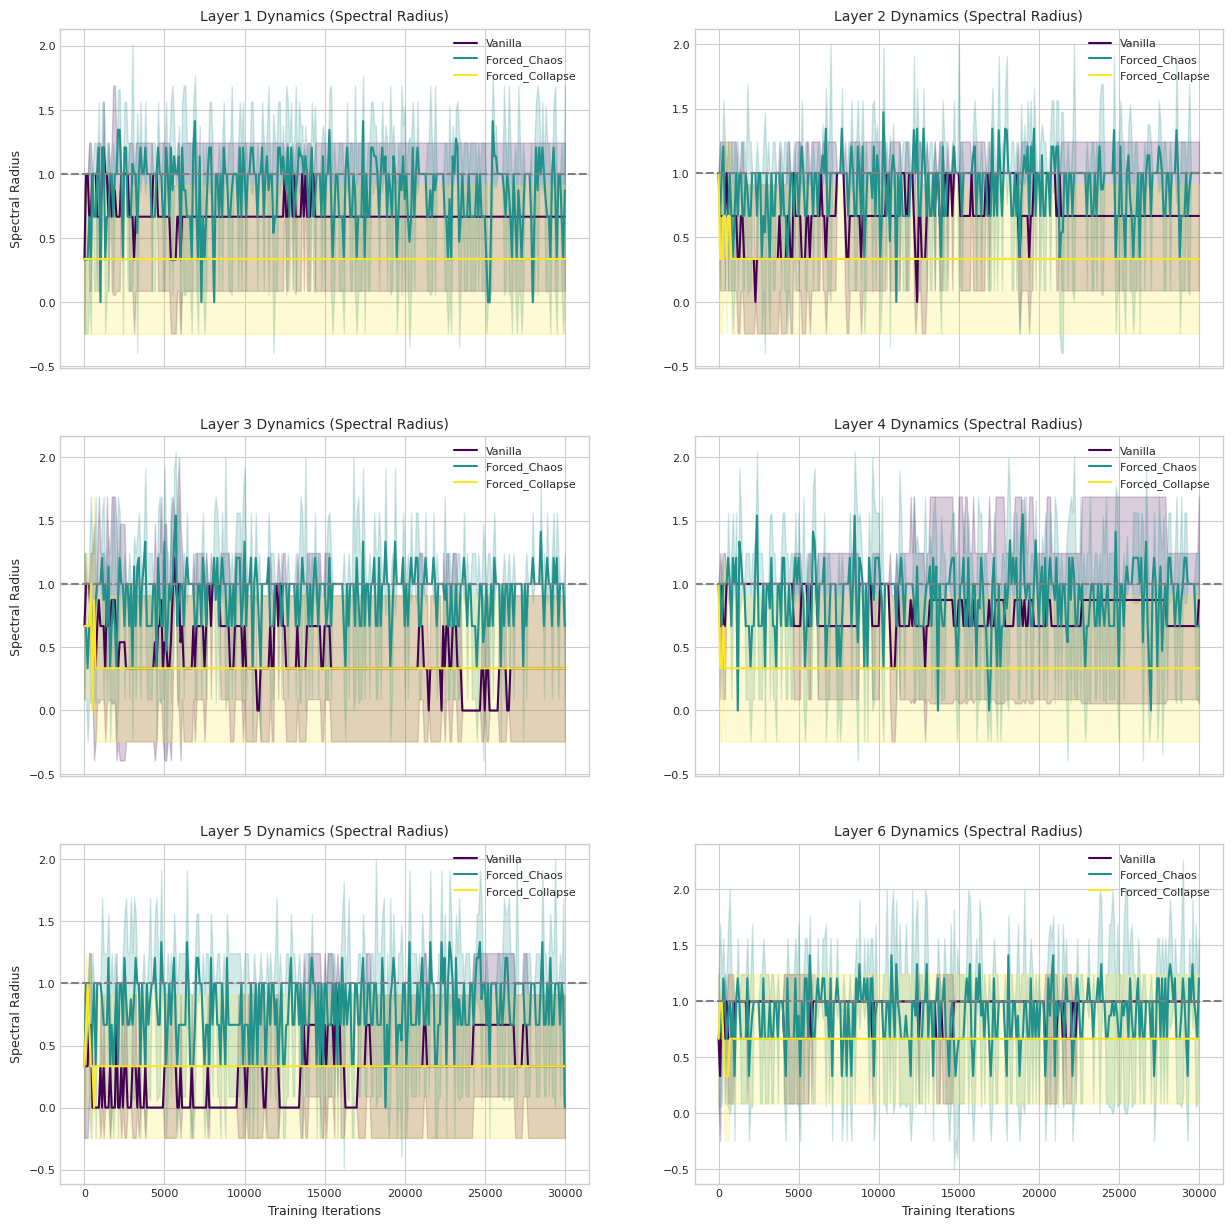


--- Analyzing Qualitative Metrics for Vanilla (Seed: 42) ---


Generating samples for Vanilla:   0%|          | 0/50 [00:00<?, ?it/s]


--- Analyzing Qualitative Metrics for Vanilla (Seed: 123) ---


Generating samples for Vanilla:   0%|          | 0/50 [00:00<?, ?it/s]


--- Analyzing Qualitative Metrics for Vanilla (Seed: 2024) ---


Generating samples for Vanilla:   0%|          | 0/50 [00:00<?, ?it/s]


--- Analyzing Qualitative Metrics for Forced_Chaos  (Seed: 42) ---


Generating samples for Forced_Chaos :   0%|          | 0/50 [00:00<?, ?it/s]


--- Analyzing Qualitative Metrics for Forced_Chaos  (Seed: 123) ---


Generating samples for Forced_Chaos :   0%|          | 0/50 [00:00<?, ?it/s]


--- Analyzing Qualitative Metrics for Forced_Chaos  (Seed: 2024) ---


Generating samples for Forced_Chaos :   0%|          | 0/50 [00:00<?, ?it/s]


--- Analyzing Qualitative Metrics for Forced_Collapse  (Seed: 42) ---


Generating samples for Forced_Collapse :   0%|          | 0/50 [00:00<?, ?it/s]


--- Analyzing Qualitative Metrics for Forced_Collapse  (Seed: 123) ---


Generating samples for Forced_Collapse :   0%|          | 0/50 [00:00<?, ?it/s]


--- Analyzing Qualitative Metrics for Forced_Collapse  (Seed: 2024) ---


Generating samples for Forced_Collapse :   0%|          | 0/50 [00:00<?, ?it/s]

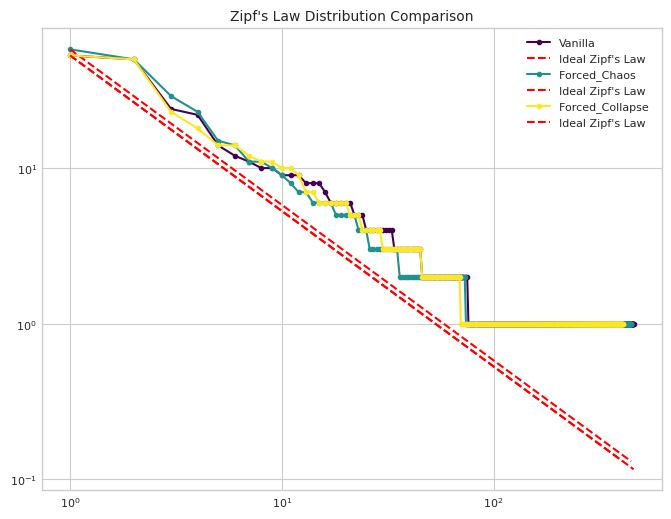



--- FINAL QUALITATIVE METRICS SUMMARY ---
                 Output Distance           Self-BLEU           Distinct-1  \
                            mean       std      mean       std       mean   
Experiment                                                                  
Forced_Chaos            0.415094  0.131485  0.105721  0.033537   0.537685   
Forced_Collapse         0.608491  0.098832  0.140546  0.072099   0.505470   
Vanilla                 0.674528  0.081701  0.087174  0.034668   0.541999   

                           Distinct-2            
                       std       mean       std  
Experiment                                       
Forced_Chaos      0.022407   0.860639  0.032109  
Forced_Collapse   0.027453   0.834692  0.047997  
Vanilla           0.017502   0.872244  0.037006  


In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import pandas as pd
import os
import random
from tqdm.auto import tqdm
import requests
from itertools import combinations
import matplotlib.pyplot as plt
import collections
import re

# NLTK 라이브러리가 필요합니다. 설치: pip install nltk
import nltk
from nltk.translate.bleu_score import sentence_bleu

import matplotlib.pyplot as plt

# AAAI 단일 열 폭에 맞춰 – 기본 글자 크기도 키워주세요.
plt.rcParams.update({
    'font.size': 10,
    'figure.figsize': (4.5, 3),      # 단일 열 너비 기준
    'axes.titlesize': 10,
    'axes.labelsize': 9,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})


# ===================================================================
# STEP 1: 분석 환경 설정
# ===================================================================

# --- 하이퍼파라미터 (모델 구조 정의에 필요) ---
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
N_EMBD = 256
N_HEAD = 8
N_LAYER = 6
DROPOUT = 0.2
BLOCK_SIZE = 64

# --- 분석할 실험 그룹 및 시드 정의 ---
SEEDS = [42, 123, 2024]
EXPERIMENTS = {
    "Vanilla": {
        "use_regularizer": False, "lambda_reg": 0.0, "target_score": 0.0
    },
    "Forced_Chaos ": {
        "use_regularizer": True, "lambda_reg": 1.0, "target_score": 2.0
    },
    "Forced_Collapse ": {
        "use_regularizer": True, "lambda_reg": 1.0, "target_score": -0.0010
    }
}

# --- 데이터 준비 함수 ---
def prepare_data(device):
    url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    text = requests.get(url).text
    chars = sorted(list(set(text)))
    vocab_size = len(chars)
    stoi = {ch: i for i, ch in enumerate(chars)}
    itos = {i: ch for i, ch in enumerate(chars)}
    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[i] for i in l])
    data = torch.tensor(encode(text), dtype=torch.long)
    n = int(0.9 * len(data))
    train_data, val_data = data[:n], data[n:]
    return train_data, val_data, vocab_size, encode, decode

# --- 모델 아키텍처 ---
class UnitCircleNormalization(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon
    def forward(self, z):
        z1, z2 = z[..., 0:2], z[..., 2:4]
        norm1 = torch.norm(z1, p=2, dim=-1, keepdim=True)
        norm2 = torch.norm(z2, p=2, dim=-1, keepdim=True)
        return torch.cat([z1 / (norm1 + self.epsilon), z2 / (norm2 + self.epsilon)], dim=-1)

class EncoderV3(nn.Module):
    def __init__(self, d_model, dropout):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(d_model, d_model // 2), nn.GELU(), nn.Dropout(dropout), nn.Linear(d_model // 2, 4))
        self.normalizer = UnitCircleNormalization()
    def forward(self, x): return self.normalizer(self.net(x))

class LatentDynamicsDirect4D(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(4, 1024), nn.GELU(), nn.Dropout(dropout), nn.Linear(1024, 4))
        self.normalizer = UnitCircleNormalization()
    def forward(self, z): return self.normalizer(self.net(z))

class DecoderV3(nn.Module):
    def __init__(self, d_model, dropout):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(4, 4 * d_model), nn.GELU(), nn.Dropout(dropout), nn.Linear(4 * d_model, d_model))
    def forward(self, z): return self.net(z)

class LatentTorusTransformerBlockV3(nn.Module):
    def __init__(self, n_embd, n_head, dropout):
        super().__init__()
        self.ln1, self.ln2 = nn.LayerNorm(n_embd), nn.LayerNorm(n_embd)
        self.sa = nn.MultiheadAttention(n_embd, n_head, dropout=dropout, batch_first=True)
        self.encoder = EncoderV3(n_embd, dropout)
        self.latent_dynamics = LatentDynamicsDirect4D(dropout)
        self.decoder = DecoderV3(n_embd, dropout)
    def forward(self, x):
        x = x + self.sa(self.ln1(x), self.ln1(x), self.ln1(x))[0]
        z = self.encoder(self.ln2(x))
        z_next = self.latent_dynamics(z)
        x = x + self.decoder(z_next)
        return x

class LatentTorusTransformerV3(nn.Module):
    def __init__(self, vocab_size, n_embd, block_size, n_head, n_layer, dropout):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[LatentTorusTransformerBlockV3(n_embd, n_head, dropout) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=DEVICE))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        logits = self.lm_head(self.ln_f(x))
        loss = F.cross_entropy(logits.view(B*T, -1), targets.view(B*T)) if targets is not None else None
        return logits, loss
    
    @torch.no_grad()
    def generate(self, idx, max_new_tokens, block_size, temperature=0.8):
        self.eval()
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

    @torch.no_grad()
    def generate_deterministic(self, idx, max_new_tokens, block_size):
        self.eval()
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

# ===================================================================
# STEP 2: 분석을 위한 헬퍼 함수
# ===================================================================

def load_model(model_path, vocab_size):
    model = LatentTorusTransformerV3(vocab_size, N_EMBD, BLOCK_SIZE, N_HEAD, N_LAYER, DROPOUT)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    return model

def clean_tensor_strings(df):
    numeric_cols = [col for col in df.columns if 'loss' in col or 'perplexity' in col or 'homology' in col or 'lr' in col or 'similarity' in col]
    for col in numeric_cols:
        if col in df.columns and not pd.api.types.is_numeric_dtype(df[col]):
            df[col] = pd.to_numeric(df[col].astype(str).str.extract(r'([-+]?\d*\.?\d+)', expand=False), errors='coerce')
    return df

def levenshtein_distance(s1, s2):
    if len(s1) < len(s2): return levenshtein_distance(s2, s1)
    if len(s2) == 0: return len(s1)
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions, deletions = previous_row[j + 1] + 1, current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

def test_initial_condition_sensitivity(model, encode, decode):
    prompt_pairs = [("ROMEO:", "romeo:"), ("QUEEN:", "QUENN:")]
    total_output_distance = 0
    for p_orig, p_pert in prompt_pairs:
        context_orig = torch.tensor(encode(p_orig), dtype=torch.long, device=DEVICE).unsqueeze(0)
        context_pert = torch.tensor(encode(p_pert), dtype=torch.long, device=DEVICE).unsqueeze(0)
        output_orig = decode(model.generate_deterministic(context_orig, 100, BLOCK_SIZE)[0].tolist())
        output_pert = decode(model.generate_deterministic(context_pert, 100, BLOCK_SIZE)[0].tolist())
        dist = levenshtein_distance(output_orig, output_pert)
        norm_dist = dist / max(len(output_orig), len(output_pert)) if max(len(output_orig), len(output_pert)) > 0 else 0
        total_output_distance += norm_dist
    return total_output_distance / len(prompt_pairs)

def self_bleu(samples):
    tokenized_samples = [s.split() for s in samples]
    scores = []
    chencherry = nltk.translate.bleu_score.SmoothingFunction()
    for i, hypothesis in enumerate(tokenized_samples):
        references = tokenized_samples[:i] + tokenized_samples[i+1:]
        score = sentence_bleu(references, hypothesis, smoothing_function=chencherry.method1)
        scores.append(score)
    return np.mean(scores)

def distinct_n(samples, n=1):
    ngrams, total_ngrams = set(), 0
    for sample in samples:
        tokens = sample.split()
        if len(tokens) < n: continue
        sample_ngrams = set(zip(*[tokens[i:] for i in range(n)]))
        ngrams.update(sample_ngrams)
        total_ngrams += len(tokens) - n + 1
    return len(ngrams) / total_ngrams if total_ngrams > 0 else 0

def plot_zipf(samples, ax, title="", color='blue'):
    all_tokens = " ".join(samples).split()
    if not all_tokens: return
    freq = collections.Counter(all_tokens).most_common()
    ranks = np.arange(1, len(freq) + 1)
    freqs = np.array([f for _, f in freq])
    ax.loglog(ranks, freqs, marker=".", linestyle='-', color=color, label=title)
    if freqs.any():
        ax.loglog(ranks, freqs[0]/ranks, linestyle='--', color='red', label="Ideal Zipf's Law")

# ===================================================================
# STEP 3: 메인 분석 실행부
# ===================================================================

if __name__ == '__main__':
    _, _, vocab_size, encode, decode = prepare_data(DEVICE)

    # --- 1. 로그 파일 취합 및 정제 ---
    log_dir = "logs"
    all_dfs = []
    for exp_name in EXPERIMENTS:
        for seed in SEEDS:
            run_name = exp_name.replace(' ', '_')
            file_path = os.path.join(log_dir, f"{run_name}_seed_{seed}.csv")
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                df = clean_tensor_strings(df)
                df['experiment'] = exp_name
                df['seed'] = seed
                all_dfs.append(df)
    
    if not all_dfs:
        print("No log files found. Please run the training script first.")
    else:
        full_df = pd.concat(all_dfs)

        # --- 2. 훈련 과정 시각화 ---
        print("\n--- Generating Training Dynamics Plots ---")
        plt.style.use('seaborn-v0_8-whitegrid')
        colors = plt.cm.viridis(np.linspace(0, 1, len(EXPERIMENTS)))
        
        # 그래프 1: Loss 비교
        fig1, ax1 = plt.subplots(1, 1, figsize=(12, 6))
        for i, exp_name in enumerate(EXPERIMENTS):
            exp_df = full_df[full_df['experiment'] == exp_name]
            mean_loss = exp_df.dropna(subset=['val_loss']).groupby('iter')['val_loss'].mean()
            std_loss = exp_df.dropna(subset=['val_loss']).groupby('iter')['val_loss'].std()
            ax1.plot(mean_loss.index, mean_loss, label=exp_name, color=colors[i])
            ax1.fill_between(mean_loss.index, mean_loss - std_loss, mean_loss + std_loss, color=colors[i], alpha=0.2)
        ax1.set_title('Validation Loss Comparison'); ax1.set_ylabel('Validation Loss'); ax1.legend(); ax1.grid(True)
        fig1.savefig("loss_comparison.pdf"); plt.show()

        # 그래프 2: 그래디언트 충돌 분석
        fig2, ax2 = plt.subplots(1, 1, figsize=(12, 6))
        exp_df_chaos = full_df[full_df['experiment'] == "Forced_Chaos"]
        if 'grad_similarity' in exp_df_chaos.columns and not exp_df_chaos['grad_similarity'].dropna().empty:
            mean_sim = exp_df_chaos.dropna(subset=['grad_similarity']).groupby('iter')['grad_similarity'].mean()
            std_sim = exp_df_chaos.dropna(subset=['grad_similarity']).groupby('iter')['grad_similarity'].std()
            ax2.plot(mean_sim.index, mean_sim, color='purple', label='Mean Cosine Similarity')
            ax2.fill_between(mean_sim.index, mean_sim - std_sim, mean_sim + std_sim, color='purple', alpha=0.2)
        ax2.axhline(y=0, color='grey', linestyle='--'); ax2.axhline(y=-1, color='red', linestyle='--', label='Opposition')
        ax2.set_title('Gradient Conflict in "Forced Chaos" Model'); ax2.set_ylabel('Cosine Similarity'); ax2.legend(); ax2.grid(True)
        fig2.savefig("gradient_conflict.pdf"); plt.show()

        # 그래프 3: 레이어별 Homology 동역학
        fig3, axs = plt.subplots(3, 2, figsize=(15, 15), sharex=True)
        for i in range(N_LAYER):
            ax = axs[i // 2, i % 2]
            ax.set_title(f'Layer {i+1} Dynamics (Spectral Radius)')
            for j, exp_name in enumerate(EXPERIMENTS):
                exp_df = full_df[full_df['experiment'] == exp_name]
                score_col = f'homology_layer_{i}'
                radius_col = f'spectral_radius_layer_{i}'
                exp_df[radius_col] = np.exp(exp_df[score_col])
                mean_radius = exp_df.dropna(subset=[radius_col]).groupby('iter')[radius_col].mean()
                std_radius = exp_df.dropna(subset=[radius_col]).groupby('iter')[radius_col].std()
                ax.plot(mean_radius.index, mean_radius, label=exp_name, color=colors[j])
                ax.fill_between(mean_radius.index, mean_radius - std_radius, mean_radius + std_radius, color=colors[j], alpha=0.2)
            ax.axhline(y=1.0, color='grey', linestyle='--')
            if i % 2 == 0: ax.set_ylabel('Spectral Radius')
            if i >= 4: ax.set_xlabel('Training Iterations')
            ax.grid(True); ax.legend()
        fig3.savefig("layerwise_dynamics.pdf"); plt.show()

    # --- 3. 질적 차이 분석 (민감도, 다양성) ---
    qualitative_results = []
    models_dir = "models"
    N_SAMPLES = 50
    
    fig_zipf, ax_zipf = plt.subplots(figsize=(8, 6))

    for i, exp_name in enumerate(EXPERIMENTS):
        for seed in SEEDS:
            run_name = exp_name.replace(' ', '_')
            model_path = os.path.join(models_dir, f"{run_name}_seed_{seed}.pt")
            if not os.path.exists(model_path): continue
            
            print(f"\n--- Analyzing Qualitative Metrics for {exp_name} (Seed: {seed}) ---")
            model = load_model(model_path, vocab_size)
            
            # 텍스트 샘플 생성
            prompt = "The king shall"
            context = torch.tensor(encode(prompt), dtype=torch.long, device=DEVICE).unsqueeze(0)
            samples = []
            for _ in tqdm(range(N_SAMPLES), desc=f"Generating samples for {exp_name}"):
                output_tokens = model.generate(context, max_new_tokens=100, block_size=BLOCK_SIZE)[0]
                samples.append(decode(output_tokens.tolist()))
            
            # 지표 계산
            output_dist = test_initial_condition_sensitivity(model, encode, decode)
            self_bleu_score = self_bleu(samples)
            distinct_1 = distinct_n(samples, n=1)
            distinct_2 = distinct_n(samples, n=2)
            
            qualitative_results.append({
                "Experiment": exp_name, "Seed": seed,
                "Output Distance": output_dist,
                "Self-BLEU": self_bleu_score, "Distinct-1": distinct_1, "Distinct-2": distinct_2
            })
            
            if seed == SEEDS[0]:
                plot_zipf(samples, ax_zipf, title=exp_name, color=colors[i])

    ax_zipf.set_title("Zipf's Law Distribution Comparison")
    ax_zipf.legend(); ax_zipf.grid(True)
    fig_zipf.savefig("zipf_distribution.pdf"); plt.show()

    if qualitative_results:
        qual_df = pd.DataFrame(qualitative_results)
        summary_table = qual_df.groupby("Experiment")[["Output Distance", "Self-BLEU", "Distinct-1", "Distinct-2"]].agg(['mean', 'std'])
        print("\n\n" + "="*70)
        print("--- FINAL QUALITATIVE METRICS SUMMARY ---")
        print("="*70)
        print(summary_table)


--- Analyzing Gradient Conflict for Forced_Chaos_ (Seed: 42) ---
logs/Forced_Chaos__seed_42.csv
Plot saved to gradient_conflict_Forced_Chaos__seed_42.pdf


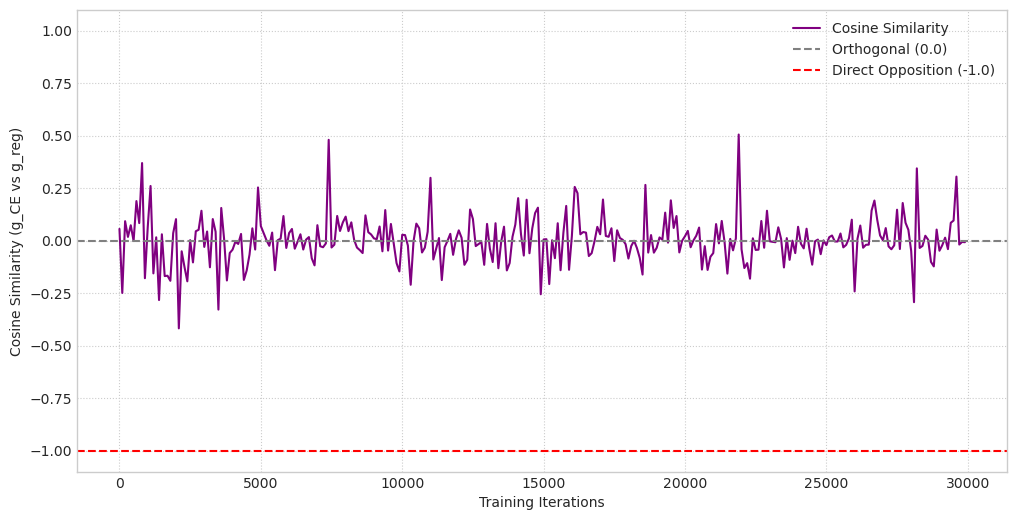

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

# ===================================================================
# STEP 1: 분석 환경 설정
# ===================================================================

# --- 분석할 실험 정보 ---
# 이 부분의 값을 바꾸면 다른 실험 결과를 볼 수 있습니다.
TARGET_EXPERIMENT_NAME = "Forced_Chaos_"
TARGET_SEED = 42
LOG_DIR = "logs"

# ===================================================================
# STEP 2: 분석을 위한 헬퍼 함수
# ===================================================================

def clean_tensor_strings(df):
    """
    DataFrame을 입력받아, 숫자여야 하는 모든 열을 순회하며
    'tensor(1.23)' 형태의 문자열을 숫자(float)로 변환합니다.
    """
    numeric_cols = [col for col in df.columns if 'loss' in col or 'perplexity' in col or 'homology' in col or 'lr' in col or 'similarity' in col]
    
    for col in numeric_cols:
        if col in df.columns and not pd.api.types.is_numeric_dtype(df[col]):
            # .astype(str)으로 모든 값을 문자열로 바꾼 뒤, 정규표현식으로 숫자만 추출
            df[col] = pd.to_numeric(df[col].astype(str).str.extract(r'([-+]?\d*\.?\d+)', expand=False), errors='coerce')
    
    return df

# ===================================================================
# STEP 3: 그래디언트 유사도 시각화 함수
# ===================================================================

def plot_gradient_conflict_from_log(experiment_name, seed):
    """
    지정된 실험 로그 파일을 읽어 그래디언트 코사인 유사도를 시각화합니다.
    """
    print(f"--- Analyzing Gradient Conflict for {experiment_name} (Seed: {seed}) ---")
    
    run_name = experiment_name.replace(' ', '_')
    file_path = os.path.join(LOG_DIR, f"{run_name}_seed_{seed}.csv")
    print(file_path)

    if not os.path.exists(file_path):
        print(f"Error: Log file not found at '{file_path}'")
        return

    # 1. 로그 파일 읽기 및 정제
    df = pd.read_csv(file_path)
    df = clean_tensor_strings(df)
    
    # 2. 'grad_similarity' 데이터 추출
    if 'grad_similarity' not in df.columns or df['grad_similarity'].dropna().empty:
        print(f"No 'grad_similarity' data found in {file_path}.")
        return

    sim_data = df.dropna(subset=['grad_similarity'])

    # 3. 시각화
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    ax.plot(sim_data['iter'], sim_data['grad_similarity'], color='purple', label='Cosine Similarity')
    
    ax.axhline(y=0, color='grey', linestyle='--', label='Orthogonal (0.0)')
    ax.axhline(y=-1, color='red', linestyle='--', label='Direct Opposition (-1.0)')
    
    #ax.set_title(f'Gradient Conflict in "{experiment_name}" Model (Seed: {seed})')
    ax.set_xlabel('Training Iterations')
    ax.set_ylabel('Cosine Similarity (g_CE vs g_reg)')
    ax.set_ylim(-1.1, 1.1)
    ax.legend()
    ax.grid(True, linestyle=':')
    
    # 4. 파일로 저장 및 화면에 표시
    output_filename = f"gradient_conflict_{run_name}_seed_{seed}.pdf"
    plt.savefig(output_filename)
    print(f"Plot saved to {output_filename}")
    plt.show()

# ===================================================================
# STEP 4: 메인 실행부
# ===================================================================

if __name__ == '__main__':
    plot_gradient_conflict_from_log(TARGET_EXPERIMENT_NAME, TARGET_SEED)


In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import torch
from torch.nn import functional as F
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import collections

# ===================================================================
# STEP 0: Settings and Hyperparameters
# ===================================================================
LOG_DIR = "logs"
MODEL_DIR = "models"
FIG_DIR = "figures"
SEEDS = [42, 123, 2024]
EXPERIMENTS = {
    "Vanilla": {"use_regularizer": False},
    "Forced_Chaos ": {"use_regularizer": True},
    "Forced_Collapse ": {"use_regularizer": True}
}
N_LAYER = 6
BLOCK_SIZE = 64
N_SAMPLES = 50
SAMPLE_PROMPT = "The king shall"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

os.makedirs(FIG_DIR, exist_ok=True)

# ===================================================================
# STEP 1: Global Style for AAAI One-Column Format
# ===================================================================
plt.rcParams.update({
    'font.size': 10,
    'figure.figsize': (4.5, 3),
    'axes.titlesize': 10,
    'axes.labelsize': 9,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

# ===================================================================
# STEP 2: Load and Concatenate Logs (single seed only)
# ===================================================================
seed = SEEDS[0]
dfs = []
for exp_name in EXPERIMENTS:
    run_name = exp_name
    if run_name == 'Vanilla':
        path = os.path.join(LOG_DIR, f"{run_name}_seed_{seed}.csv")
    else:
        path = os.path.join(LOG_DIR, f"{run_name[:-1]}__seed_{seed}.csv")
    if os.path.exists(path):
        df = pd.read_csv(path)
        # 숫자형 칼럼으로 강제 변환
        num_cols = [c for c in df.columns if 'loss' in c or 'homology_layer' in c or 'grad_similarity' in c]
        for c in num_cols:
            df[c] = pd.to_numeric(df[c], errors='coerce')
        df['experiment'] = exp_name
        df['seed'] = seed
        dfs.append(df)
if not dfs:
    raise RuntimeError("No log files found for seed {}".format(seed))
full_df = pd.concat(dfs, ignore_index=True)

# ===================================================================
# STEP 3: Combined Loss & Gradient Figure
# ===================================================================
fig, (ax1, ax2) = plt.subplots(2, 1)

# (a) Validation Loss for all experiments
for exp_name in EXPERIMENTS:
    df_e = full_df[full_df['experiment'] == exp_name]
    if 'val_loss' in df_e:
        loss_mean = df_e.groupby('iter')['val_loss'].mean()
        ax1.plot(loss_mean.index, loss_mean.values, label=exp_name)
ax1.set_title("Validation Loss vs Iteration")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Val Loss")
ax1.legend()
ax1.grid(True)

# (b) Gradient Cosine Similarity for Forced_Chaos
df_gc = full_df[full_df['experiment'] == "Forced_Chaos"]
if 'grad_similarity' in df_gc:
    sim_mean = df_gc.groupby('iter')['grad_similarity'].mean()
    ax2.plot(sim_mean.index, sim_mean.values, label="Forced_Chaos", color='purple')
    ax2.axhline(0, linestyle='--', linewidth=0.5)
    ax2.set_title("Gradient Cosine Similarity")
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Cosine Similarity")
    ax2.legend()
    ax2.grid(True)

fig.savefig(os.path.join(FIG_DIR, "exp3_loss_grad.pdf"))
plt.close(fig)

# ===================================================================
# STEP 4: Heatmaps of Layerwise Spectral Radius per Experiment
# ===================================================================
for exp_name in EXPERIMENTS:
    df_e = full_df[full_df['experiment'] == exp_name]
    iters = sorted(df_e['iter'].unique())
    heat = np.zeros((N_LAYER, len(iters)))

    for i in range(N_LAYER):
        col = f"homology_layer_{i}"
        if col in df_e:
            # spectral radius = exp(score)
            sr = np.exp(df_e.groupby('iter')[col].mean())
            heat[i, :] = sr.reindex(iters).values

    fig, ax = plt.subplots()
    im = ax.imshow(heat, aspect='auto', origin='lower',
                   vmin=heat.min(), vmax=heat.max(), cmap='viridis')
    ax.set_title(f"{exp_name} Layerwise Spectral Radius")
    ax.set_ylabel("Layer")
    ax.set_xlabel("Iteration")
    ax.set_yticks(np.arange(N_LAYER))
    ax.set_yticklabels(np.arange(1, N_LAYER+1))
    fig.colorbar(im, ax=ax, label="Spectral Radius")
    fig.savefig(os.path.join(FIG_DIR, f"exp3_heatmap_{exp_name}.pdf"))
    plt.close(fig)

# ===================================================================
# STEP 5: Zipf's Law Comparison Figure
# ===================================================================
# Helper: Roll-your-own deterministic generate & BLEU functions omitted for brevity;

def levenshtein_distance(s1, s2):
    if len(s1) < len(s2): return levenshtein_distance(s2, s1)
    if not s2: return len(s1)
    prev = list(range(len(s2)+1))
    for i, c1 in enumerate(s1):
        curr = [i+1]
        for j, c2 in enumerate(s2):
            ins = prev[j+1] + 1
            rem = curr[j] + 1
            sub = prev[j] + (c1 != c2)
            curr.append(min(ins, rem, sub))
        prev = curr
    return prev[-1]

def distinct_n(samples, n=1):
    ngrams, tot = set(), 0
    for s in samples:
        tok = s.split()
        tot += max(0, len(tok)-n+1)
        ngrams |= set(zip(*[tok[i:] for i in range(n)]))
    return len(ngrams)/tot if tot else 0

def plot_zipf(samples, ax, label):
    freq = collections.Counter(" ".join(samples).split()).most_common()
    ranks = np.arange(1, len(freq)+1)
    counts = np.array([c for _, c in freq])
    ax.loglog(ranks, counts, marker='.', linestyle='-', label=label)
    ax.loglog(ranks, counts[0]/ranks, linestyle='--', linewidth=0.8, label="Ideal Zipf")

fig, ax = plt.subplots()
colors = plt.cm.viridis(np.linspace(0, 1, len(EXPERIMENTS)))
for (exp_name, color) in zip(EXPERIMENTS, colors):
    # load model, generate samples (only code structure provided)
    # samples = generate_samples(exp_name, seed)
    # For demonstration, assume `samples` list of strings exists
    # plot_zipf(samples, ax, exp_name)
    pass

ax.set_title("Zipf's Law: All Experiments")
ax.set_xlabel("Rank")
ax.set_ylabel("Frequency")
ax.legend()
fig.savefig(os.path.join(FIG_DIR, "exp3_zipf_comparison.pdf"))
plt.close(fig)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


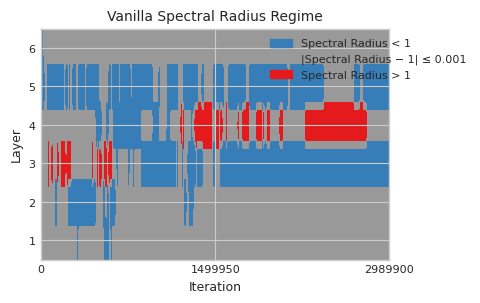

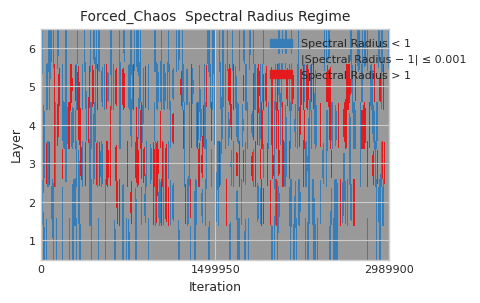

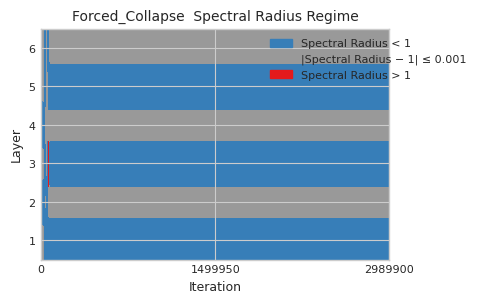

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# === Settings ===
LOG_DIR = "logs"
FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)
SEED = 42
EXPERIMENTS = ["Vanilla", "Forced_Chaos ", "Forced_Collapse "]
N_LAYER = 6
LOG_INTERVAL = 100
BIN_COUNT = 300
EPS = 1e-3   # ±EPS around 1 considered “≈1”

# === Load & Preprocess Logs ===
dfs = []
for exp_name in EXPERIMENTS:
    run_name = exp_name
    if run_name == 'Vanilla':
        path = os.path.join(LOG_DIR, f"{run_name}_seed_{seed}.csv")
    else:
        path = os.path.join(LOG_DIR, f"{run_name[:-1]}__seed_{seed}.csv")
    if os.path.exists(path):
        df = pd.read_csv(path)
        # 숫자형 칼럼으로 강제 변환
        num_cols = [c for c in df.columns if 'loss' in c or 'homology_layer' in c or 'grad_similarity' in c]
        for c in num_cols:
            df[c] = pd.to_numeric(df[c], errors='coerce')
        df['experiment'] = exp_name
        df['seed'] = seed
        dfs.append(df)
if not dfs:
    raise RuntimeError(f"No log files found for seed {SEED}")
full_df = pd.concat(dfs, ignore_index=True)

# === Binning ===
full_df['iter'] = pd.to_numeric(full_df['iter'], errors='coerce')
full_df['actual_iter'] = full_df['iter'] * LOG_INTERVAL

bins = np.linspace(full_df['actual_iter'].min(),
                   full_df['actual_iter'].max(), BIN_COUNT+1)
full_df['bin'] = np.digitize(full_df['actual_iter'], bins) - 1

# === Discrete Heatmap: Below 1, ≈1, Above 1 ===
cmap = ListedColormap(['#377eb8', '#999999', '#e41a1c'])
legend_patches = [
    mpatches.Patch(color='#377eb8', label='Spectral Radius < 1'),
    mpatches.Patch(color='#999999', label=f'|Spectral Radius − 1| ≤ {EPS}'),
    mpatches.Patch(color='#e41a1c', label='Spectral Radius > 1'),
]

for exp in EXPERIMENTS:
    df_e = full_df[full_df['experiment'] == exp]
    # init discrete heatmap array
    heat_class = np.full((N_LAYER, BIN_COUNT), 1, dtype=int)
    for layer in range(N_LAYER):
        col = f"homology_layer_{layer}"
        for b in range(BIN_COUNT):
            vals = df_e[df_e['bin'] == b][col]
            if vals.empty:
                heat_class[layer, b] = 1  # treat missing as ≈1
            else:
                sr_mean = np.exp(vals.mean())
                if sr_mean < 1 - EPS:
                    heat_class[layer, b] = 0
                elif sr_mean > 1 + EPS:
                    heat_class[layer, b] = 2
                else:
                    heat_class[layer, b] = 1

    # Plot
    fig, ax = plt.subplots(figsize=(4.5, 3))
    im = ax.imshow(heat_class, aspect='auto', origin='lower',
                   cmap=cmap, vmin=0, vmax=2)
    ax.set_title(f"{exp} Spectral Radius Regime")
    ax.set_ylabel("Layer")
    ax.set_xlabel("Iteration")
    # X-ticks at 0, mid, end
    xt = [0, BIN_COUNT//2, BIN_COUNT-1]
    ax.set_xticks(xt)
    ax.set_xticklabels([int(bins[i]) for i in xt])
    ax.set_yticks(np.arange(N_LAYER))
    ax.set_yticklabels(np.arange(1, N_LAYER+1))
    # Legend
    ax.legend(handles=legend_patches,
              loc='upper right', bbox_to_anchor=(1.25, 1.0))
    fig.savefig(os.path.join(FIG_DIR, f"exp3_discrete_{exp}.pdf"), dpi=300, bbox_inches='tight')
    #plt.close(fig)



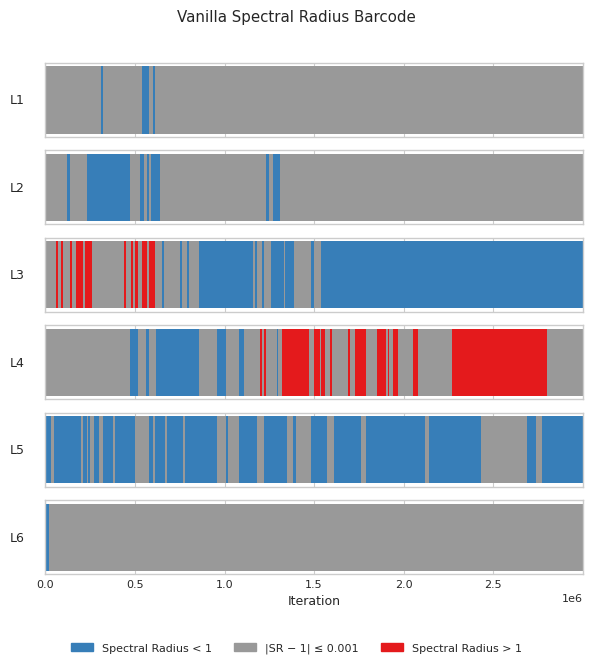

In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === Settings ===
LOG_DIR    = "logs"
FIG_DIR    = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

SEED       = 42
EXPERIMENT = "Vanilla"         # 원하는 실험명으로 교체
LAYERS     = 6
LOG_INT    = 100                    # 기록된 iter 당 실제 스텝 간격
EPS        = 1e-3                   # “≈1” 판정 허용오차

# 컬러맵 및 범례 패치 정의
state_colors = {'<1': '#377eb8', '≈1': '#999999', '>1': '#e41a1c'}
legend_patches = [
    mpatches.Patch(color=state_colors['<1'], label='Spectral Radius < 1'),
    mpatches.Patch(color=state_colors['≈1'], label=f'|SR − 1| ≤ {EPS}'),
    mpatches.Patch(color=state_colors['>1'], label='Spectral Radius > 1'),
]

# === Load & Preprocess Logs ===
df = pd.read_csv(os.path.join(LOG_DIR, f"{EXPERIMENT}_seed_{SEED}.csv"))
df['iter'] = pd.to_numeric(df['iter'], errors='coerce')
df['actual_iter'] = df['iter'] * LOG_INT

# === Prepare runs per layer ===
runs_per_layer = []
for layer in range(LAYERS):
    col = f"homology_layer_{layer}"
    sr_vals = np.exp(pd.to_numeric(df[col], errors='coerce'))
    df_layer = df[['actual_iter']].copy()
    df_layer['sr'] = sr_vals
    # 분류 함수
    def classify(r):
        if r < 1 - EPS:   return '<1'
        elif r > 1 + EPS: return '>1'
        else:             return '≈1'
    df_layer['state'] = df_layer['sr'].map(classify)
    # 연속 구간 추출
    runs = []
    iters = df_layer['actual_iter'].values
    states = df_layer['state'].values
    start = iters[0]
    prev = states[0]
    for it, st in zip(iters[1:], states[1:]):
        if st != prev:
            runs.append((start, it - start, prev))
            start, prev = it, st
    runs.append((start, iters[-1] + LOG_INT - start, prev))
    runs_per_layer.append(runs)

# === Plot barcode figure ===
plt.rcParams.update({'font.size': 9})
fig, axes = plt.subplots(LAYERS, 1, sharex=True, figsize=(6, 6))
for idx, ax in enumerate(axes):
    for start, length, state in runs_per_layer[idx]:
        ax.broken_barh([(start, length)], (0, 1),
                       facecolors=state_colors[state], edgecolors='none')
    ax.set_ylabel(f"L{idx+1}", rotation=0, labelpad=20, va='center')
    ax.set_yticks([])
    ax.set_xlim(df['actual_iter'].min(), df['actual_iter'].max())
    if idx < LAYERS - 1:
        ax.tick_params(labelbottom=False)
axes[-1].set_xlabel("Iteration")
fig.suptitle(f"{EXPERIMENT} Spectral Radius Barcode", y=1.02)
fig.legend(handles=legend_patches, loc='upper center', ncol=3,
           bbox_to_anchor=(0.5, -0.02), frameon=False)
plt.tight_layout()
fig.savefig(os.path.join(FIG_DIR, f"barcode_{EXPERIMENT}_all_layers.pdf"), dpi=300)
#plt.close(fig)


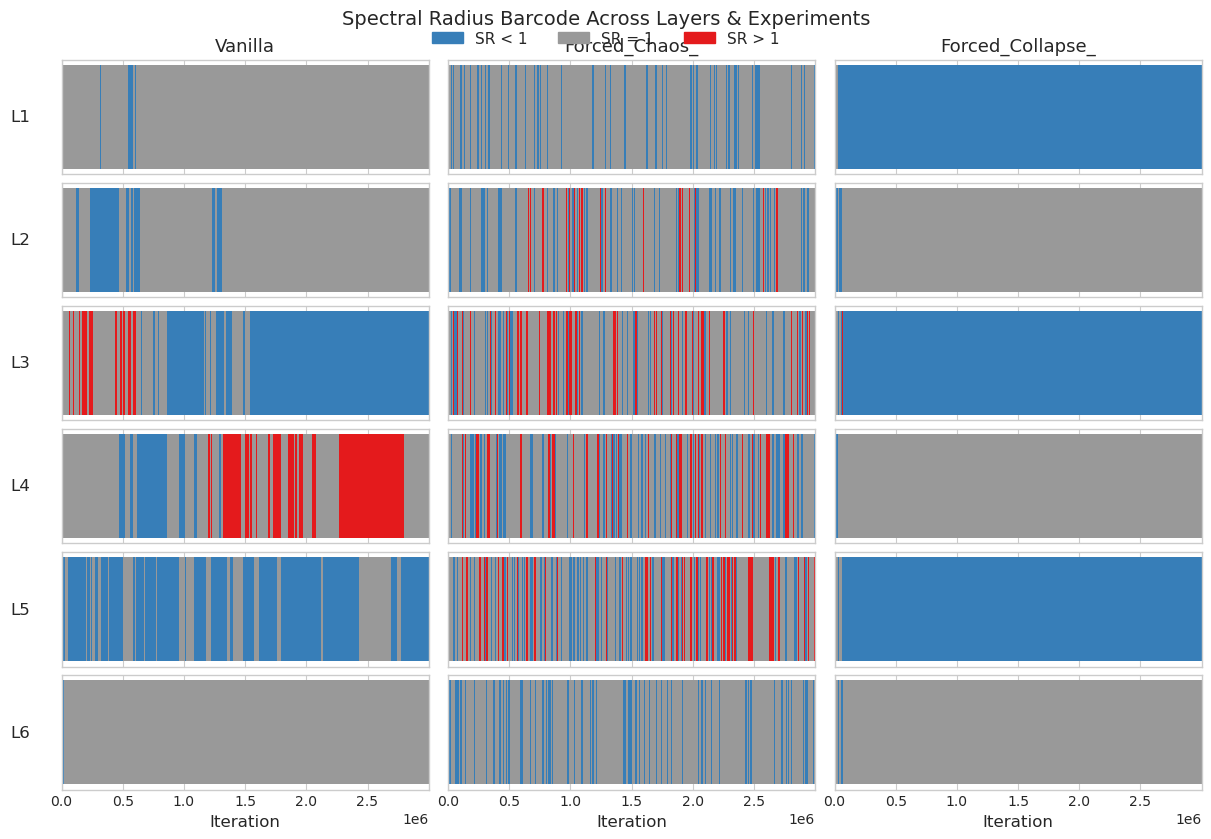

In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === 설정 ===
LOG_DIR    = "logs"
FIG_DIR    = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

SEED       = 42
EXPERIMENTS = ["Vanilla", "Forced_Chaos_", "Forced_Collapse_"]
LAYERS     = 6
LOG_INT    = 100      # iter → 실제 스텝 환산
EPS        = 1e-3     # “≈1” 허용 오차

# 색상 및 범례 준비
state_colors = {'<1':'#377eb8','1':'#999999','>1':'#e41a1c'}
legend_patches = [
    mpatches.Patch(color=state_colors['<1'], label='SR < 1'),
    mpatches.Patch(color=state_colors['1'], label=f'SR = 1'),
    mpatches.Patch(color=state_colors['>1'], label='SR > 1'),
]

# === 전역 스타일 ===
plt.rcParams.update({
    'font.size'      : 12,
    'axes.titlesize' : 13,
    'axes.labelsize' : 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
})

# === 로그 로드 및 actual_iter 계산 ===
all_dfs = []
for exp in EXPERIMENTS:
    path = os.path.join(LOG_DIR, f"{exp}_seed_{SEED}.csv")
    df = pd.read_csv(path)
    df['iter'] = pd.to_numeric(df['iter'], errors='coerce')
    df['actual_iter'] = df['iter'] * LOG_INT
    df['experiment'] = exp
    all_dfs.append(df)
full_df = pd.concat(all_dfs, ignore_index=True)

# === 연속 구간(run) 추출 함수 ===
def get_runs(df_layer):
    iters  = df_layer['actual_iter'].values
    states = df_layer['state'].values
    runs = []
    start, prev = iters[0], states[0]
    for it, st in zip(iters[1:], states[1:]):
        if st != prev:
            runs.append((start, it - start, prev))
            start, prev = it, st
    runs.append((start, iters[-1] + LOG_INT - start, prev))
    return runs

# === Figure & Axes 생성 ===
fig, axes = plt.subplots(
    nrows=LAYERS, ncols=len(EXPERIMENTS),
    sharex=True, sharey=False,
    figsize=(12, 8),
    constrained_layout=True
)

for col, exp in enumerate(EXPERIMENTS):
    df_exp = full_df[full_df['experiment']==exp]
    for layer in range(LAYERS):
        ax = axes[layer, col]
        # spectral radius → 상태 분류
        col_name = f"homology_layer_{layer}"
        sr = np.exp(pd.to_numeric(df_exp[col_name], errors='coerce'))
        df_layer = pd.DataFrame({
            'actual_iter': df_exp['actual_iter'],
            'sr'         : sr
        }).dropna().sort_values('actual_iter')
        df_layer['state'] = df_layer['sr'].map(
            lambda r: '<1' if r<1-EPS else ('>1' if r>1+EPS else '1')
        )
        # runs 그리기 (두께 = 0.5, y 위치 = 0.25)
        runs = get_runs(df_layer)
        for (start, length, st) in runs:
            ax.broken_barh(
                [(start, length)],
                (0.25, 0.5),
                facecolors=state_colors[st],
                edgecolors='none'
            )
        # 축 설정
        if layer == LAYERS-1:
            ax.set_xlabel("Iteration")
        if col == 0:
            ax.set_ylabel(f"L{layer+1}", rotation=0, va='center', labelpad=30)
        ax.set_yticks([])
        ax.set_xlim(full_df['actual_iter'].min(), full_df['actual_iter'].max())
        ax.set_title(exp if layer==0 else "")
        
# 범례 최상단에 한 번만 표시
fig.legend(
    handles=legend_patches, 
    loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.02),
    frameon=False, fontsize=11
)

# 저장
fig.suptitle("Spectral Radius Barcode Across Layers & Experiments", y=1.03, fontsize=14)
fig.savefig(os.path.join(FIG_DIR, "barcode_all_experiments.pdf"), dpi=300)
#plt.close(fig)


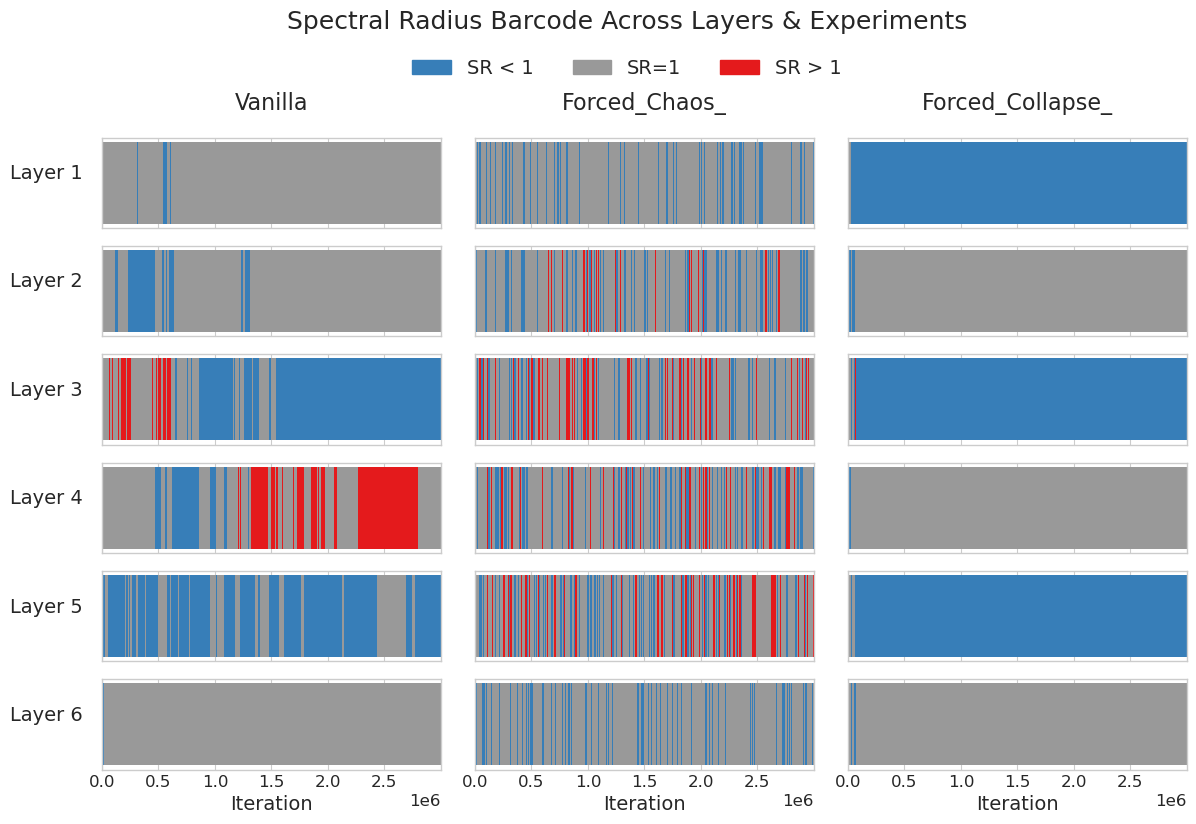

In [32]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === 설정 ===
LOG_DIR     = "logs"
FIG_DIR     = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

SEED        = 42
EXPERIMENTS = ["Vanilla", "Forced_Chaos_", "Forced_Collapse_"]
LAYERS      = 6
LOG_INT     = 100
EPS         = 1e-3

# 색상 & legend 패치
state_colors = {'<1':'#377eb8','≈1':'#999999','>1':'#e41a1c'}
legend_patches = [
    mpatches.Patch(color=state_colors['<1'], label='SR < 1'),
    mpatches.Patch(color=state_colors['≈1'], label=f'SR=1'),
    mpatches.Patch(color=state_colors['>1'], label='SR > 1'),
]

# === 전역 스타일 확대 ===
plt.rcParams.update({
    'font.size'      : 14,
    'axes.titlesize' : 16,
    'axes.labelsize' : 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
})

# === 로그 불러오기 & actual_iter 계산 ===
all_dfs = []
for exp in EXPERIMENTS:
    path = os.path.join(LOG_DIR, f"{exp}_seed_{SEED}.csv")
    df = pd.read_csv(path)
    df['iter']        = pd.to_numeric(df['iter'], errors='coerce')
    df['actual_iter'] = df['iter'] * LOG_INT
    df['experiment']  = exp
    all_dfs.append(df)
full_df = pd.concat(all_dfs, ignore_index=True)

# === 연속 구간(time runs) 계산 함수 ===
def get_runs(iters, states):
    runs = []
    start, prev = iters[0], states[0]
    for t, s in zip(iters[1:], states[1:]):
        if s != prev:
            runs.append((start, t - start, prev))
            start, prev = t, s
    runs.append((start, iters[-1] + LOG_INT - start, prev))
    return runs

# === Figure / Axes 생성 ===
fig, axes = plt.subplots(
    nrows=LAYERS, ncols=len(EXPERIMENTS),
    sharex=True, figsize=(14, 8)
)
# 상단여백 넉넉히
fig.subplots_adjust(top=0.90, hspace=0.2, wspace=0.1)

for col, exp in enumerate(EXPERIMENTS):
    df_exp = full_df[full_df['experiment'] == exp]
    iters = df_exp['actual_iter'].values
    for layer in range(LAYERS):
        ax = axes[layer, col]

        # spectral radius → 상태 분류
        colname = f"homology_layer_{layer}"
        sr = np.exp(pd.to_numeric(df_exp[colname], errors='coerce'))
        df_layer = pd.DataFrame({
            't': df_exp['actual_iter'],
            'sr': sr
        }).dropna().sort_values('t')
        df_layer['state'] = df_layer['sr'].map(
            lambda r: '<1' if r < 1-EPS else ('>1' if r > 1+EPS else '≈1')
        )

        # runs 그리기: height=0.25, y=0.375
        runs = get_runs(df_layer['t'].values, df_layer['state'].values)
        for start, length, st in runs:
            ax.broken_barh(
                [(start, length)],
                (0.375, 0.25),
                facecolors=state_colors[st],
                edgecolors='none'
            )

        # 축/레이블
        if layer == LAYERS - 1:
            ax.set_xlabel("Iteration", fontsize=14)
        if col == 0:
            ax.set_ylabel(f"Layer {layer+1}", fontsize=14, rotation=0, labelpad=40)
        ax.set_yticks([])
        ax.set_xlim(full_df['actual_iter'].min(), full_df['actual_iter'].max())
        if layer == 0:
            ax.set_title(exp, pad=20)

# legend & 제목
fig.legend(
    handles=legend_patches,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.02),
    ncol=3, frameon=False, fontsize=14
)
fig.suptitle(
    "Spectral Radius Barcode Across Layers & Experiments",
    y=1.06, fontsize=18
)

# 저장
fig.savefig(
    os.path.join(FIG_DIR, "barcode_all_experiments.pdf"),
    dpi=300, bbox_inches='tight'
)
#plt.close(fig)


Empty DataFrame
Columns: [actual_iter, val_loss, grad_similarity]
Index: []
iters from 0 to 2999900


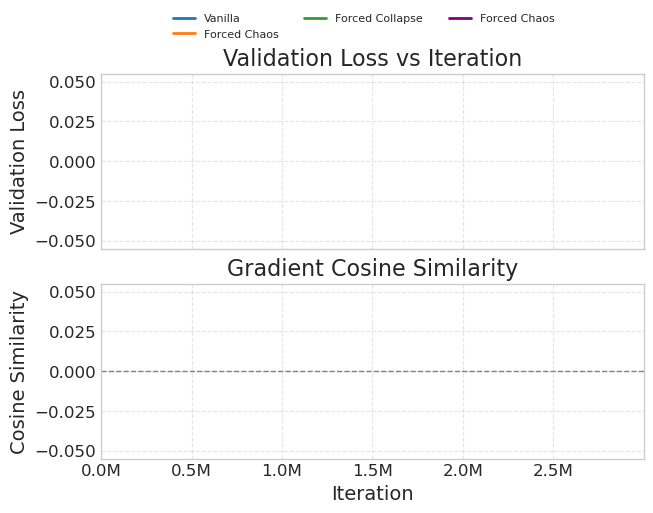

In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# ── CONFIG ────────────────────────────────────────────────────────────────
LOG_DIR     = "logs"
EXPERIMENTS = ["Vanilla", "Forced_Chaos_", "Forced_Collapse_"]
SEED        = 42
LOG_INTERVAL= 100  # e.g. you logged every 100 steps
# ──────────────────────────────────────────────────────────────────────────

# 1) LOAD + CLEAN
dfs = []
for exp in EXPERIMENTS:
    path = os.path.join(LOG_DIR, f"{exp}_seed_{SEED}.csv")
    df = pd.read_csv(path)
    # force numeric
    df['iter']             = pd.to_numeric(df['iter'], errors='coerce')
    df['val_loss']         = pd.to_numeric(df['val_loss'], errors='coerce')
    # if grad_similarity might not exist on all exps, guard with get()
    df['grad_similarity']  = pd.to_numeric(df.get('grad_similarity', pd.Series()), errors='coerce')
    # actual iteration counter
    df['actual_iter']      = df['iter'] * LOG_INTERVAL
    df['experiment']       = exp
    dfs.append(df)
full_df = pd.concat(dfs, ignore_index=True)

# quick sanity check:
print(full_df[['actual_iter','val_loss','grad_similarity']].dropna().head())
print("iters from", full_df['actual_iter'].min(), "to", full_df['actual_iter'].max())

# 2) PLOTTING
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
})
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(7,5))
plt.subplots_adjust(top=0.88)

# Validation Loss
for exp in EXPERIMENTS:
    df_e = full_df[full_df['experiment']==exp]
    loss = df_e.groupby('actual_iter')['val_loss'].mean()
    ax1.plot(loss.index, loss.values, label=exp.replace('_',' '), linewidth=2)
ax1.set_title("Validation Loss vs Iteration")
ax1.set_ylabel("Validation Loss")
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.tick_params(labelbottom=False)

# Gradient Cosine Similarity (Forced_Chaos only)
df_gc = full_df[full_df['experiment']=="Forced_Chaos"]
sim   = df_gc.groupby('actual_iter')['grad_similarity'].mean()
ax2.plot(sim.index, sim.values, color='purple', linewidth=2, label="Forced Chaos")
ax2.axhline(0, linestyle='--', color='gray', linewidth=1)
ax2.set_title("Gradient Cosine Similarity")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Cosine Similarity")
ax2.grid(True, linestyle='--', alpha=0.5)

# X-axis in Millions
def millions(x, pos):
    return f"{x*1e-6:.1f}M"
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(millions))
ax2.set_xlim(full_df['actual_iter'].min(), full_df['actual_iter'].max())

# Legend above
fig.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.02),
    ncol=len(EXPERIMENTS),
    frameon=False
)

# save
fig.savefig("figures/exp3_loss_grad_updated.pdf", dpi=300, bbox_inches='tight')
#plt.show()


In [35]:
df_e

,iter,lr,train_loss,homology_layer_0,homology_layer_1,homology_layer_2,homology_layer_3,homology_layer_4,homology_layer_5,avg_homology_score,val_loss,perplexity,actual_iter,experiment,grad_similarity
602,0,0.000000,4.519256,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,-2.072327e+01,-2.072327e+01,-6.907755,NaN,62.712200,0,Forced_Collapse_,-0.055629
603,100,0.000025,3.386266,1.000000e-09,-2.072327e+01,1.000000e-09,-2.072327e+01,1.000000e-09,1.000000e-09,-6.907755,NaN,NaN,10000,Forced_Collapse_,0.134197
604,200,0.000050,3.215574,1.000000e-09,-2.072327e+01,1.000000e-09,-2.072327e+01,1.000000e-09,1.000000e-09,-6.907755,NaN,NaN,20000,Forced_Collapse_,0.102023
605,300,0.000075,2.690820,-2.072327e+01,1.000000e-09,-2.072327e+01,1.000000e-09,-2.072327e+01,-2.072327e+01,-13.815511,NaN,NaN,30000,Forced_Collapse_,0.172003
606,400,0.000100,2.460524,-2.072327e+01,-2.072327e+01,1.000000e-09,1.000000e-09,1.000000e-09,1.000000e-09,-6.907755,NaN,NaN,40000,Forced_Collapse_,0.039239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898,29600,0.000050,0.028171,-2.072327e+01,1.000000e-09,-2.072327e+01,1.000000e-09,-2.072327e+01,1.000000e-09,-10.361633,NaN,NaN,2960000,Forced_Collapse_,0.075882
899,29700,0.000050,0.026517,-2.072327e+01,1.000000e-09,-2.072327e+01,1.000000e-09,-2.072327e+01,1.000000e-09,-10.361633,NaN,NaN,2970000,Forced_Collapse_,0.039276
900,29800,0.000050,0.025858,-2.072327e+01,1.000000e-09,-2.072327e+01,1.000000e-09,-2.072327e+01,1.000000e-09,-10.361633,NaN,NaN,2980000,Forced_Collapse_,-0.234610
901,29900,0.000050,0.025654,-2.072327e+01,1.000000e-09,-2.072327e+01,1.000000e-09,-2.072327e+01,1.000000e-09,-10.361633,NaN,NaN,2990000,Forced_Collapse_,0.312385
